In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bgp_qnm_fits as bgp

from matplotlib.colors import LinearSegmentedColormap
from plot_config import PlotConfig
from matplotlib.lines import Line2D

In [2]:
id = "0001"

In [36]:
TRAINING_START_TIME = -10
TRAINING_END_TIME = 310
TIME_STEP = 0.1

analysis_times = np.arange(TRAINING_START_TIME, TRAINING_START_TIME + TRAINING_END_TIME, TIME_STEP)

tuned_params_news = bgp.get_tuned_param_dict("GP", data_type="news")[id]
R_news = bgp.get_residual_data(big=True, data_type="news")[id]

t1 = analysis_times
t2 = analysis_times

kernel_news = bgp.compute_kernel_matrix_test(t1, t2, tuned_params_news[(2,2)], bgp.kernel_GP_test, regularization_factor=1e2)
#kernel_news = bgp.kernel_GP_test(t1, t2, **tuned_params_news[(2,2)])

In [40]:
dt = t1[1] - t1[0]

R_strain = bgp.get_residual_data(big=True, data_type="strain")[id]
tuned_params_strain = bgp.get_tuned_param_dict("GP", data_type="strain")[id]

# Compute the kernel matrix at required shifted points
K = bgp.compute_kernel_matrix_test(t1, t2, tuned_params_strain[(2,2)], bgp.kernel_GP_test, regularization_factor=1e2)
K_t1p = bgp.compute_kernel_matrix_test(t1 + dt, t2, tuned_params_strain[(2,2)], bgp.kernel_GP_test, regularization_factor=1e2)
K_t1m = bgp.compute_kernel_matrix_test(t1 - dt, t2, tuned_params_strain[(2,2)], bgp.kernel_GP_test, regularization_factor=1e2)
K_t2p = bgp.compute_kernel_matrix_test(t1, t2 + dt, tuned_params_strain[(2,2)], bgp.kernel_GP_test, regularization_factor=1e2)
K_t2m = bgp.compute_kernel_matrix_test(t1, t2 - dt, tuned_params_strain[(2,2)], bgp.kernel_GP_test, regularization_factor=1e2)
K_t1p_t2p = bgp.compute_kernel_matrix_test(t1 + dt, t2 + dt, tuned_params_strain[(2,2)], bgp.kernel_GP_test, regularization_factor=1e2)
K_t1p_t2m = bgp.compute_kernel_matrix_test(t1 + dt, t2 - dt, tuned_params_strain[(2,2)], bgp.kernel_GP_test, regularization_factor=1e2)
K_t1m_t2p = bgp.compute_kernel_matrix_test(t1 - dt, t2 + dt, tuned_params_strain[(2,2)], bgp.kernel_GP_test, regularization_factor=1e2)
K_t1m_t2m = bgp.compute_kernel_matrix_test(t1 - dt, t2 - dt, tuned_params_strain[(2,2)], bgp.kernel_GP_test, regularization_factor=1e2)

# Central difference formula for mixed second derivative
kernel_strain_derivative = (
    K_t1p_t2p - K_t1p_t2m - K_t1m_t2p + K_t1m_t2m
) / (4 * dt**2)

/tmp/ipykernel_1604009/3244710686.py:3: RuntimeWarning: invalid value encountered in sqrt
  std_strain_deriv = np.sqrt(np.diag(kernel_strain_derivative))


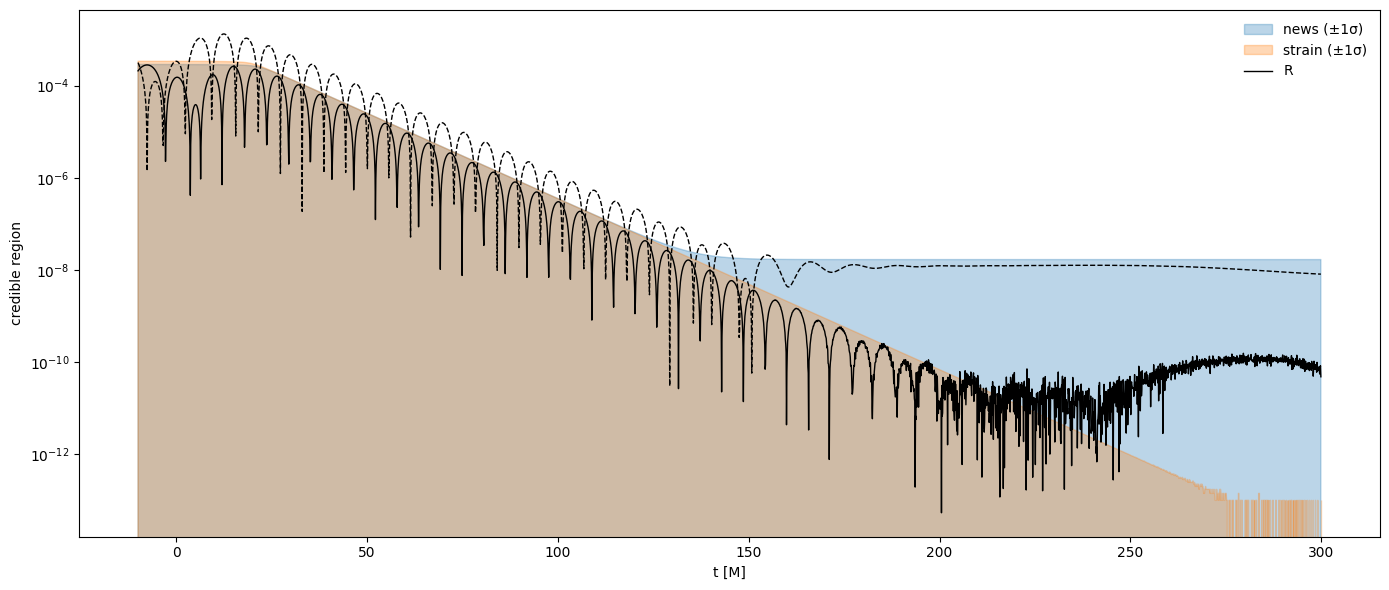

In [41]:
# 1σ credible regions (diagonal std dev)
std_news = np.sqrt(np.diag(kernel_news))
std_strain_deriv = np.sqrt(np.diag(kernel_strain_derivative))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.fill_between(analysis_times, -std_news, std_news, color="C0", alpha=0.3, label="news (±1σ)")
ax.fill_between(analysis_times, -std_strain_deriv, std_strain_deriv, color="C1", alpha=0.3, label="strain (±1σ)")

ax.plot(analysis_times, np.abs(np.real(R_news[(2,2)])), color="k", lw=1, label="R")
ax.plot(analysis_times, np.abs(np.real(R_strain[(2,2)])), color="k", ls="--", lw=1)

ax.set_xlabel("t [M]")
ax.set_ylabel("credible region")
ax.set_yscale("log")
ax.legend(frameon=False)
plt.tight_layout()
plt.show()